In [1]:
import pandas as pd
from pyproj import Transformer
import matplotlib.pyplot as plt
import glob
from os.path import join as pjoin

from metacatalog import api

In [2]:
UPLOAD  = True

# Local
# DATA = './data'
# CONNECTION = 'lubw_upload'

# portal.vforwater.de
DATA = '/data/lubw/download'
CONNECTION = 'default'

In [3]:
session = api.connect_database(CONNECTION)
print(session.bind)

ArgumentError: Could not parse rfc1738 URL from string 'default'

In [4]:
raw = pd.read_csv(pjoin(DATA, 'Stammdaten', 'Stammdaten.txt'), sep=';', decimal=',', encoding='ISO-8859-1')
raw.head()

,MESSTELLEN_NR,STANDORT,GEWAESSER,MESSNETZ,PEGELTYP,NUTZUNG,ENTFERNUNG_MUENDUNG,EINZUGSGEBIET_OBERIRDISCH,DATEN_VORH_SEIT,PEGELDIAGRAMM_SEIT,...,HOCHWERT,STATUS,AUFGABE_KLEINE_EZG,AUFGABE_FLIWAS,AUFGABE_KLIWA,AUFGABE_QUELLMESSNETZ,AUFGEHOBEN_SEIT,BL_DATENAUSTAUSCH,OSTWERT,NORDWERT
0,105,Kirchen-Hausen,Donau,1,1,1.0,2761.076,758.528,05.09.1922,01.11.1922,...,5309755,1,0,1.0,1,0,NaN,0.0,NaN,NaN
1,106,Möhringen,Donau,1,1,1.0,2753.047,826.963,01.11.1924,01.11.1966,...,5312341,1,0,1.0,0,0,NaN,0.0,NaN,NaN
2,120,Hundersingen,Donau,1,1,1.0,2662.716,2621.324,01.11.1929,01.11.1938,...,5326121,1,0,1.0,1,0,NaN,0.0,NaN,NaN
3,125,Berg,Donau,1,1,1.0,2613.000,4072.790,01.11.1929,01.11.1935,...,5347854,1,0,1.0,1,0,NaN,1.0,NaN,NaN
4,129,Achstetten,Baierzer Rot,1,1,1.0,6.072,264.393,01.11.1922,01.11.1951,...,5347673,1,0,1.0,0,0,NaN,0.0,NaN,NaN


### Create a dummy Person entry who acts as the owner of the LUBW data

In [5]:
lubw = api.find_person(session, organisation_abbrev='LUBW', last_name=None, return_iterator=True).first()

if lubw is None and UPLOAD:
    lubw = api.add_person(session, first_name=None, last_name=None, 
                          organisation_name='Landesanstalt für Umwelt Baden-Württemberg',
                          affiliation='LUBW Landesanstalt für Umwelt Baden-Württemberg, Karlsruhe, Germany.',
                          organisation_abbrev='LUBW',
                          attribution="Grundlage: Daten aus dem Umweltinformationssystem (UIS) der LUBW Landesanstalt für Umwelt Baden-Württemberg"
                         )

print(lubw)

None <ID=1>


### Variables & Units
W: water level [cm], 1h / 15 minute average   
Q: discharge   [m³/s], 1h / 15 minute average

In [6]:
var_Q = api.find_variable(session, name='discharge', return_iterator=True).first()
var_W = api.find_variable(session, name='river water level', return_iterator=True).first()
print(var_Q, var_W)

discharge [m3/s] <ID=4> river water level [m] <ID=18>


Both variables exist, but river water level is stored in meters! -> transform data from cm to m!

### Location

In [7]:
t = Transformer.from_crs('epsg:31467', 'epsg:4326', always_xy=True)

In [8]:
locations = ['SRID=4326;POINT (%f %f)' % t.transform(r[0], r[1]) for i, r in raw[['RECHTSWERT', 'HOCHWERT']].iterrows()]

### License
Check and update!

In [9]:
lic = api.find_license(session, short_title='CC BY %', return_iterator=True ).first()
print(lic)

Creative Commons Attribution 4.0 International <ID=6>


### Metadata

In [10]:
df = raw.copy()

1) START WITH ONE ENTRY  
2) FUNCTION  
3) glob.glob() Dateipfad *      
4) LOOP over FUNCTION


Every location gets 2 entries (Q & W)

In [11]:
df['title'] = df.STANDORT.map(lambda n: 'LUBW gauge data: %s' % n)
df['location'] = locations
#df['abstract']
df['external_id'] = df.MESSTELLEN_NR
#df['comment']
df['license_id'] = lic.id


df.head()

,MESSTELLEN_NR,STANDORT,GEWAESSER,MESSNETZ,PEGELTYP,NUTZUNG,ENTFERNUNG_MUENDUNG,EINZUGSGEBIET_OBERIRDISCH,DATEN_VORH_SEIT,PEGELDIAGRAMM_SEIT,...,AUFGABE_KLIWA,AUFGABE_QUELLMESSNETZ,AUFGEHOBEN_SEIT,BL_DATENAUSTAUSCH,OSTWERT,NORDWERT,title,location,external_id,license_id
0,105,Kirchen-Hausen,Donau,1,1,1.0,2761.076,758.528,05.09.1922,01.11.1922,...,1,0,NaN,0.0,NaN,NaN,LUBW gauge data: Kirchen-Hausen,SRID=4326;POINT (8.679572 47.925516),105,6
1,106,Möhringen,Donau,1,1,1.0,2753.047,826.963,01.11.1924,01.11.1966,...,0,0,NaN,0.0,NaN,NaN,LUBW gauge data: Möhringen,SRID=4326;POINT (8.760098 47.948970),106,6
2,120,Hundersingen,Donau,1,1,1.0,2662.716,2621.324,01.11.1929,01.11.1938,...,1,0,NaN,0.0,NaN,NaN,LUBW gauge data: Hundersingen,SRID=4326;POINT (9.396086 48.072465),120,6
3,125,Berg,Donau,1,1,1.0,2613.000,4072.790,01.11.1929,01.11.1935,...,1,0,NaN,1.0,NaN,NaN,LUBW gauge data: Berg,SRID=4326;POINT (9.731446 48.266271),125,6
4,129,Achstetten,Baierzer Rot,1,1,1.0,6.072,264.393,01.11.1922,01.11.1951,...,0,0,NaN,0.0,NaN,NaN,LUBW gauge data: Achstetten,SRID=4326;POINT (9.900807 48.263440),129,6


delete columns:  
'RECHTSWERT' and 'HOCHWERT' already in 'location'  
columns 'AUFGEHOBEN_SEIT', 'OSTWERT' and 'NORDWERT' are empty

rest of the columns is put into details later

In [12]:
df.drop(['RECHTSWERT', 'HOCHWERT', 'AUFGEHOBEN_SEIT', 'OSTWERT', 'NORDWERT', 'MESSTELLEN_NR'], axis=1, inplace=True)

In [13]:
# duplicate all entries
df = pd.concat([df]*2).sort_index()
df.reset_index(drop=True, inplace=True)

# assign variable W (water level) to one of the duplicate and variable Q (discharge) to the other duplicate
df['variable_id'] = 0
var_idx = df.columns.get_loc("variable_id")
df.iloc[0::2, var_idx] = var_Q.id
df.iloc[1::2, var_idx] = var_W.id

df.head()

,STANDORT,GEWAESSER,MESSNETZ,PEGELTYP,NUTZUNG,ENTFERNUNG_MUENDUNG,EINZUGSGEBIET_OBERIRDISCH,DATEN_VORH_SEIT,PEGELDIAGRAMM_SEIT,BETRIEB_VON_DATUM,...,AUFGABE_KLEINE_EZG,AUFGABE_FLIWAS,AUFGABE_KLIWA,AUFGABE_QUELLMESSNETZ,BL_DATENAUSTAUSCH,title,location,external_id,license_id,variable_id
0,Kirchen-Hausen,Donau,1,1,1.0,2761.076,758.528,05.09.1922,01.11.1922,01.11.1922,...,0,1.0,1,0,0.0,LUBW gauge data: Kirchen-Hausen,SRID=4326;POINT (8.679572 47.925516),105,6,4
1,Kirchen-Hausen,Donau,1,1,1.0,2761.076,758.528,05.09.1922,01.11.1922,01.11.1922,...,0,1.0,1,0,0.0,LUBW gauge data: Kirchen-Hausen,SRID=4326;POINT (8.679572 47.925516),105,6,18
2,Möhringen,Donau,1,1,1.0,2753.047,826.963,01.11.1924,01.11.1966,01.11.1924,...,0,1.0,0,0,0.0,LUBW gauge data: Möhringen,SRID=4326;POINT (8.760098 47.948970),106,6,4
3,Möhringen,Donau,1,1,1.0,2753.047,826.963,01.11.1924,01.11.1966,01.11.1924,...,0,1.0,0,0,0.0,LUBW gauge data: Möhringen,SRID=4326;POINT (8.760098 47.948970),106,6,18
4,Hundersingen,Donau,1,1,1.0,2662.716,2621.324,01.11.1929,01.11.1938,01.11.1929,...,0,1.0,1,0,0.0,LUBW gauge data: Hundersingen,SRID=4326;POINT (9.396086 48.072465),120,6,4


Rename columns for details  
Drop some columns for now, may add them later  
Use date format for the columns 'data_since' and 'since'

In [14]:
df.rename(columns={'STANDORT': 'site', 'GEWAESSER': 'waterbody', 'MESSNETZ': 'network', 'PEGELTYP': 'type', 'NUTZUNG': 'usage', 'ENTFERNUNG_MUENDUNG': 'distance', 'DATEN_VORH_SEIT': 'data_since', 'BETRIEB_VON_DATUM': 'since', 'STATUS': 'status', 'EINZUGSGEBIET_OBERIRDISCH': 'catchment'}, inplace=True)
df.drop(['AUFGABE_KLEINE_EZG', 'AUFGABE_KLEINE_EZG', 'AUFGABE_KLIWA', 'AUFGABE_FLIWAS', 'BL_DATENAUSTAUSCH', 'AUFGABE_QUELLMESSNETZ', 'PEGELDIAGRAMM_SEIT'], axis=1, inplace=True)

df['data_since'] = pd.to_datetime(df.data_since)
df['since'] = pd.to_datetime(df.since)
df['data_since'] = df['data_since'].dt.date
df['since'] = df['since'].dt.date

df.head()

,site,waterbody,network,type,usage,distance,catchment,data_since,since,status,title,location,external_id,license_id,variable_id
0,Kirchen-Hausen,Donau,1,1,1.0,2761.076,758.528,1922-05-09,1922-01-11,1,LUBW gauge data: Kirchen-Hausen,SRID=4326;POINT (8.679572 47.925516),105,6,4
1,Kirchen-Hausen,Donau,1,1,1.0,2761.076,758.528,1922-05-09,1922-01-11,1,LUBW gauge data: Kirchen-Hausen,SRID=4326;POINT (8.679572 47.925516),105,6,18
2,Möhringen,Donau,1,1,1.0,2753.047,826.963,1924-01-11,1924-01-11,1,LUBW gauge data: Möhringen,SRID=4326;POINT (8.760098 47.948970),106,6,4
3,Möhringen,Donau,1,1,1.0,2753.047,826.963,1924-01-11,1924-01-11,1,LUBW gauge data: Möhringen,SRID=4326;POINT (8.760098 47.948970),106,6,18
4,Hundersingen,Donau,1,1,1.0,2662.716,2621.324,1929-01-11,1929-01-11,1,LUBW gauge data: Hundersingen,SRID=4326;POINT (9.396086 48.072465),120,6,4


### Upload

Use the original LUBW column names as a description for the details.  
Adding the keys 'river' and 'stream' as an alternative for 'water body' as users will search for 'river' and 'stream' more often.

In [15]:
df['river'] = df['waterbody']
df['stream'] = df['waterbody']
df.head()

,site,waterbody,network,type,usage,distance,catchment,data_since,since,status,title,location,external_id,license_id,variable_id,river,stream
0,Kirchen-Hausen,Donau,1,1,1.0,2761.076,758.528,1922-05-09,1922-01-11,1,LUBW gauge data: Kirchen-Hausen,SRID=4326;POINT (8.679572 47.925516),105,6,4,Donau,Donau
1,Kirchen-Hausen,Donau,1,1,1.0,2761.076,758.528,1922-05-09,1922-01-11,1,LUBW gauge data: Kirchen-Hausen,SRID=4326;POINT (8.679572 47.925516),105,6,18,Donau,Donau
2,Möhringen,Donau,1,1,1.0,2753.047,826.963,1924-01-11,1924-01-11,1,LUBW gauge data: Möhringen,SRID=4326;POINT (8.760098 47.948970),106,6,4,Donau,Donau
3,Möhringen,Donau,1,1,1.0,2753.047,826.963,1924-01-11,1924-01-11,1,LUBW gauge data: Möhringen,SRID=4326;POINT (8.760098 47.948970),106,6,18,Donau,Donau
4,Hundersingen,Donau,1,1,1.0,2662.716,2621.324,1929-01-11,1929-01-11,1,LUBW gauge data: Hundersingen,SRID=4326;POINT (9.396086 48.072465),120,6,4,Donau,Donau


In [16]:
description = {'site': 'Standort',
               'waterbody': 'Gewässer',
               'network': 'Messnetz',
               'type': 'Pegeltyp',
               'usage': 'Nutzung',
               'distance': 'Entfernung_mündung',
               'catchment': 'Einzugsgebiet_oberirdisch',
               'data_since': 'Daten_vorh_seit',
               'since': 'Betrieb_von_datum',
               'status': 'Status',
               'river': 'Fluss',
               'stream': 'Fluss'
              }

The temporal resolution of the discharge and water level data changes from 1-hour resolution to 15-min resolution at the timestep `2016-05-01 00:00:00`.
So we need two entries with different timescales for each dataset (`entry.datasource.create_scale()`) and make these two entries an EntryGroup of type `Split dataset`.

In [21]:
if UPLOAD and False:
    for i,e in df.iterrows():
        # add the entry twice, because the temporal resolution in the data changes and therefore it has to be split up
        entry1 = api.add_entry(session, e.title, lubw.id, e.location, e.variable_id, 
                               external_id=e.external_id, license=e.license_id, is_partial=False, embargo=False)
        entry2 = api.add_entry(session, e.title, lubw.id, e.location, e.variable_id, 
                               external_id=e.external_id, license=e.license_id, is_partial=False, embargo=False)
        
        # prepare list of dictionaries containing the details for each entry
        details_list = []
        for k,v in e.to_dict().items():
            
            if k not in ['title', 'external_id', 'variable_id', 'license_id', 'location']:
                details = {
                'key': k,
                'value': str(v),
                'description': description[k]
                }
                details_list.append(details)
                        
        # add the details to the entries
        api.add_details_to_entries(session, [entry1], details_list)
        api.add_details_to_entries(session, [entry2], details_list)
        
        # add both entries to the same entry group
        entry_group = api.add_group(session, 'Split dataset', 
                               entry_ids=[entry1.id, entry2.id],
                               title=e.title,
                               description='Two datasets with the same metadata (same measuring point), covering different temporal range and resolution.'
                              )

In [22]:
entries = api.find_entry(session, author=lubw.id)
# for e in entries:
#    print(e)
print(f'Added {len(entries)} sets')

Added 988 sets


### Create the EntryGroup

In [24]:
if UPLOAD and False:
    lubw_group = api.add_group(session, 'Project', 
                               entry_ids=[e.id for e in entries],
                               title='LUBW gauge network',
                               description='The LUBW gauge network dataset contains river water level and discharge data for rivers in baden-wuerttemberg.'
                              )
print(lubw_group)

Project LUBW gauge network <ID=495>


## Data

**Data preprocessing**  
1) Convert column 'Zeit' to datetime  
2) Drop column 'Geprüft (nein=ungeprüfte Rohdaten)'  
3) Find anomalies in the data

In [25]:
data_Q = pd.read_csv(pjoin(DATA, "Landespegel/2018-09-04_00-00_105-Kirchen-Hausen-Donau_Q_hour15minMean.csv"), sep=';', decimal=',', skiprows=1, encoding='ISO-8859-1')
data_Q['Zeit'] = pd.to_datetime(data_Q.Zeit, format='%d.%m.%Y %H:%M')
data_Q.drop('Geprüft (nein=ungeprüfte Rohdaten)', axis=1, inplace=True)

data_W = pd.read_csv(pjoin(DATA, "Landespegel/2018-09-04_00-00_105-Kirchen-Hausen-Donau_W_hour15minMean.csv"), sep=';', decimal=',', skiprows=1, encoding='ISO-8859-1')
data_W['Zeit'] = pd.to_datetime(data_W.Zeit, format='%d.%m.%Y %H:%M')
data_W.drop('Geprüft (nein=ungeprüfte Rohdaten)', axis=1, inplace=True)

-999.0 -999


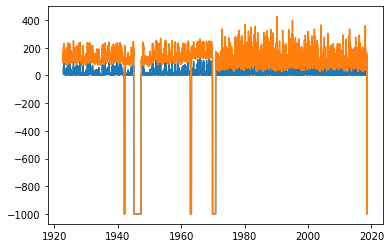

In [26]:
plt.plot(data_Q.Zeit,data_Q.Q)
plt.plot(data_W.Zeit,data_W.W)
print(min(data_Q.Q), min(data_W.W))

Looks like a value of -999.0 represents missing data -> convert to NA  
same for W (water level)!

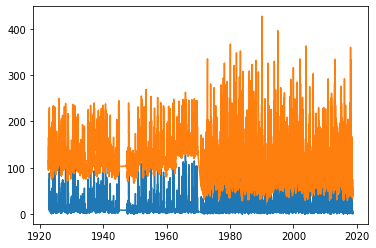

In [27]:
data_Q = data_Q.where(data_Q.Q != -999.0).dropna()
data_W = data_W.where(data_W.W != -999.0).dropna()
plt.plot(data_Q.Zeit,data_Q.Q)
plt.plot(data_W.Zeit,data_W.W)

Create datasource and uploaddata to the corresponding entries:

In [46]:
files = glob.glob(pjoin(DATA, 'Landespegel', '*.csv'))
# files only containing NaN (-999) values after '2016-05-01 00:00:00':
#files.remove('data/Landespegel\\2018-09-04_00-00_1307-Weinheim-Weschnitz_Q_hour15minMean.csv')

if UPLOAD and False:
    for idx, file in enumerate(files):
        # read data, drop and rename columns
        dat = pd.read_csv(file, sep=';', decimal=',', skiprows=1, encoding='ISO-8859-1')
        # convert to datetime, drop unnecessary column
        dat.drop('Geprüft (nein=ungeprüfte Rohdaten)', axis=1, inplace=True)
        dat.columns = ['tstamp', 'value']
        dat['tstamp'] = pd.to_datetime(dat.tstamp, format='%d.%m.%Y %H:%M')
        # drop NA values (-999.0)
        dat = dat.where(dat.value != -999.0).dropna()
        
        # split the data at timestep '2016-05-01 00:00:00' as the resolution changes from 1 hour to 15 minutes
        dat1 = dat.where(dat.tstamp <= '2016-05-01 00:00:00').dropna()
        dat2 = dat.where(dat.tstamp > '2016-05-01 00:00:00').dropna()
        
        # set tstamp column as index (necessary to use timeseries datasource)
        dat1.set_index('tstamp', inplace=True)
        dat2.set_index('tstamp', inplace=True)
        
        # get external ID and variable from file path, find corresponding entry 
        ext_id = file.split('_00-00_')[1].split('-')[0]
        var = file.split('_')[3].split('_hour')[0]
    
        if var == 'Q':
            var_id = 4
        elif var == 'W':
            var_id = 18
            # transform water level from cm to m
            dat1.value = dat1.value / 100
            dat2.value = dat2.value / 100
        else:
            print(ext_id, ': variable not found.')
        
        # find entries: the first entry found is assigned the data with 1-hour resolution, 
        #               the second entry is assigned the data with 15-min resolution
        e1 = api.find_entry(session, variable=var_id, external_id=ext_id)[0]
        e2 = api.find_entry(session, variable=var_id, external_id=ext_id)[1]
        
        # create data source and import data if the data source source does not exist yet 
        # (makes the upload process restartable as data won´t be uploaded twice if datasource already exists)
        if e1.datasource is None and e2.datasource is None:
            e1.create_datasource(type=1, path='timeseries', datatype='timeseries', commit=True)
            e2.create_datasource(type=1, path='timeseries', datatype='timeseries', commit=True)
        
            # dat1 and/or dat2 are empty for some stations if the values for one of the periods contain only -999 (these are dropped before)
            if len(dat1 > 0):
                # add data to entry
                e1.import_data(dat1)
                
                # add temporal scale
                e1.datasource.create_scale(
                    resolution='60min', 
                    extent=(dat1.index[0], dat1.index[-1]), 
                    support=1.0, # not sure 
                    scale_dimension='temporal'
                )
                
            if len(dat2 > 0):
                # add data to entry
                e2.import_data(dat2) 
                
                # add temporal scale
                e2.datasource.create_scale(
                    resolution='15min', 
                    extent=(dat2.index[0], dat2.index[-1]), 
                    support=1.0, # not sure 
                    scale_dimension='temporal'
                )
            
            session.add(e1, e2)
            session.commit()
            print('done ID=%d  loaded %d points, ID=%d  loaded %d points (%d/%d)' % (e1.id, len(dat1), e2.id, len(dat2), idx+1, len(files)))
        else:
            print('ID=%d & ID=%d: datasource already exists (%d/%d)' % (e1.id, e2.id, idx+1, len(files)))
                
else:
    print('No data was uploaded')

ID=451 & ID=452: datasource already exists (1/477)
ID=239 & ID=240: datasource already exists (2/477)
ID=320 & ID=319: datasource already exists (3/477)
ID=931 & ID=932: datasource already exists (4/477)
ID=768 & ID=767: datasource already exists (5/477)
ID=27 & ID=28: datasource already exists (6/477)
ID=893 & ID=894: datasource already exists (7/477)
done ID=253  loaded 302401 points, ID=254  loaded 82223 points (8/477)
done ID=501  loaded 766993 points, ID=502  loaded 82223 points (9/477)
done ID=295  loaded 289297 points, ID=296  loaded 82222 points (10/477)


KeyboardInterrupt: 

In [53]:
e2.create_datasource(type=1, path='timeseries', datatype='timeseries', commit=True)

MetadataMissingError: Datasource already exists. You can edit that one.

In [52]:
e2.datasource.temporal_scale

Empty Entries:

| ID  | Entry title  | dat1 (< 05/16) | dat2 (> 05/16) | var | external ID |
|---|:---|---|---|---|---|
| 366  | Weinheim  |   | empty  | Q  | 1307 |
| 30  | Blaubeuren-1  |   | empty  | Q  | 145 |
| 429  | Unterlenningen  | empty  |   | Q  | 1500 |
| 431  | Unterlenningen  | empty  |   | W  | 1500 |
| 522  | Nagold  |   | empty  | Q  | 2452 |
| 94  | Eberfingen  |   | empty  | Q  | 356 |
| 109  | St. Blasien  |   | empty  | Q  | 368 |
| 846  | Weinheim-SKA  |   | empty  | Q  | 62773 |
| 892  | Bleibach-WKA  |   | empty  | W  | 76169 |

Some additional entries should be empty, as there are more entries (494) than .csv data files (477)!

In [36]:
id366 = api.find_entry(session, id=366)[0]
id30 = api.find_entry(session, id=30)[0]
id429 = api.find_entry(session, id=429)[0]
id431 = api.find_entry(session, id=431)[0]
id522 = api.find_entry(session, id=522)[0]
id94 = api.find_entry(session, id=94)[0]
id109 = api.find_entry(session, id=109)[0]
id846 = api.find_entry(session, id=846)[0]
id892 = api.find_entry(session, id=892)[0]

len(id366.get_data() + id30.get_data() + id429.get_data() + id431.get_data() + id522.get_data() + id94.get_data() + id109.get_data() + id846.get_data() + id892.get_data())

884088

## Test

test: find both entries of a station separately

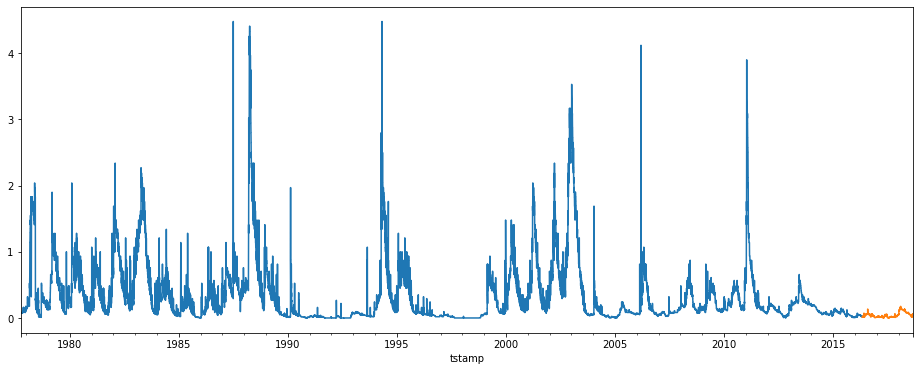

In [37]:
entries = api.find_entry(session, external_id='1137', variable=var_Q.id)

for e in entries:
    dat = e.get_data()
    dat.iloc[:,1].plot(figsize=(16,6))

test: find an entry group

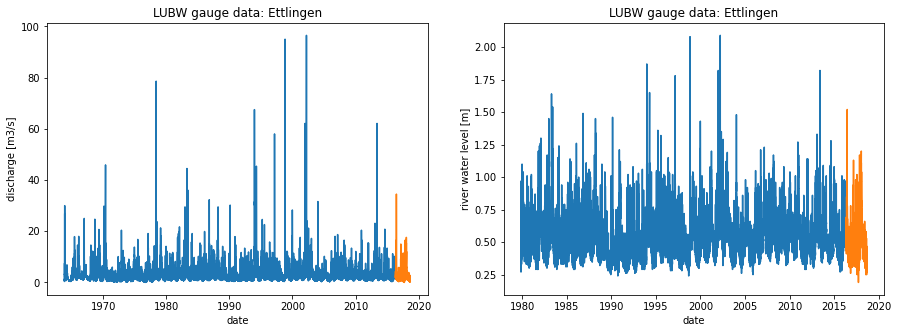

In [38]:
e_group = api.find_group(session, title='*Ettlingen*')

fig, axs = plt.subplots(1, 2, figsize=(15,5))

for idx, g in enumerate(e_group):
    
    for e in g.entries:
        dat = e.get_data()
        axs[idx].plot(dat.iloc[:,1])
        axs[idx].set_title(e.title)
        axs[idx].set_ylabel(e.variable.name + ' [' + e.variable.unit.symbol + ']')
        axs[idx].set_xlabel('date')